In [42]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
import papermill as pm
from swdf.losses import *
from swdf.metrics import *

os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# Training the Geomagnetic Index Ap

In this notebook, we implement the training process for the forecaster of the Ap index. For more information about the training process, check `geodstap_train` notebook.

In [43]:
cwd = os.getcwd()
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_geo = yaml2dict('./config/geoap.yaml', attrdict=True)
config_train = config_geo.train
config_data = config_geo.data

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_config_file is not None:
    config.arch_config_file = Path(config.arch_config_file)
    if config.arch_config_file.exists():
        config.arch = yaml2dict(config.arch_config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch_config_file}')
        config.arch = AttrDict()
else:
    config.arch = AttrDict()

In [44]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
config

```json
{ 'arch': { 'd_model': 1024,
            'decomposition': True,
            'dropout': 0.4,
            'individual': True,
            'n_heads': 16,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': Path('config/patchtst.yaml'),
  'arch_name': 'PatchTST',
  'bs': 128,
  'data': { 'data_columns': ['AP'],
            'data_nb': './geoap_data.ipynb',
            'data_path': '../data/SOLAP.TXT',
            'data_url': 'https://www-app3.gfz-potsdam.de/kp_index/Kp_ap_since_1932.txt',
            'df_save_path': './preprocessed_data/dataframes/geoap.pkl',
            'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geoap.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geoap.pkl'},
  'horizon': 24,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 96,
  'loss_config': {},
  'loss_func': 'wMSE',
  'lr_max': None,
  'main_metric': 'default',
  'metrics_handler_path': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [45]:
df, preproc_pipe, exp_pipe = generate_preprocessed_data(config.data)

df.head()

,hh._m,days,AP,Datetime
0,1.5,0.000,18,1932-01-01 00:00:00
1,4.5,0.125,12,1932-01-01 03:00:00
2,7.5,0.250,9,1932-01-01 06:00:00
3,10.5,0.375,12,1932-01-01 09:00:00
4,13.5,0.500,18,1932-01-01 12:00:00


# Train

In [46]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

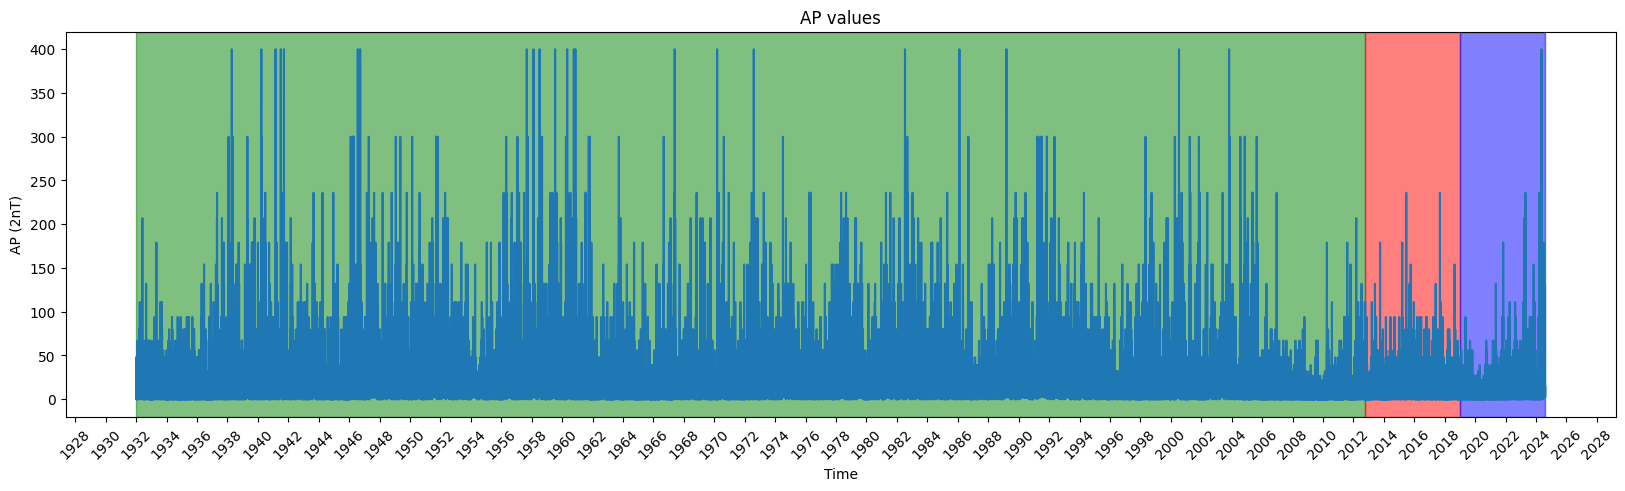

In [47]:
# hide

# Plot the variable AP, covering the different periods (training, test and validation)
# with different colors.
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df.Datetime, df.AP)
ax.axvspan(df.Datetime.min(), test_start_datetime, alpha=0.5, color='green')
ax.axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
ax.axvspan(test_end_datetime, df.Datetime.max(), alpha=0.5, color='blue')
ax.set_title('AP values')
ax.set_xlabel('Time')
ax.set_ylabel('AP (2nT)')
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.show()

In [48]:
# Test and Training sets generation
splits_ = get_forecasting_splits(
    df[df.Datetime < valid_start_datetime], 
    fcst_history=config.lookback, 
    fcst_horizon=config.horizon, 
    use_index=False, 
    test_cutoff_datetime=test_start_datetime, 
    show_plot=False, 
    datetime_col='Datetime'
)

# Validation set generation
validation_data = df[df.Datetime >= valid_start_datetime]

validation_splits = get_forecasting_splits(
    validation_data, 
    fcst_history=config.lookback, 
    fcst_horizon=config.horizon, 
    valid_size=0.0, 
    test_size=0.0, 
    show_plot=False
)

val_idxs = L(validation_data.index[validation_splits[0]].tolist())

# Combination of the different set
splits = (splits_[0], val_idxs, splits_[1])
splits


((#235838) [0,1,2,3,4,5,6,7,8,9...],
 (#19173) [251300,251301,251302,251303,251304,251305,251306,251307,251308,251309...],
 (#15320) [235861,235862,235863,235864,235865,235866,235867,235868,235869,235870...])

In [49]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, fcst_horizon=config.horizon, 
                                x_vars=config.data.data_columns, y_vars=config.data.data_columns)
X = X.astype(float)
y = y.astype(float)
X.shape, y.shape

((270473, 1, 96), (270473, 1, 24))

In [50]:
weights = {'All': load_object("preprocessed_data/weights/weights_geodstap.pkl")['AP']}
thresholds = {'AP': yaml2dict("preprocessed_data/categorization/thresholds_geodstap.yaml")['AP']}

### Train

1.737800812406931e-05
#params: 34248760


epoch,train_loss,valid_loss,time
0,443.812714,150.252914,00:18
1,458.320221,159.198181,00:18
2,473.846252,162.568344,00:18
3,520.034546,226.805695,00:18
4,588.147949,202.248077,00:18
5,616.850647,191.156403,00:18
6,602.591064,223.666718,00:18
7,691.333191,319.135681,00:18
8,685.134827,194.640030,00:18
9,640.160034,373.859222,00:18


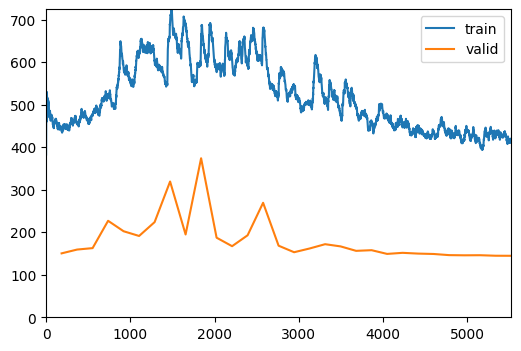

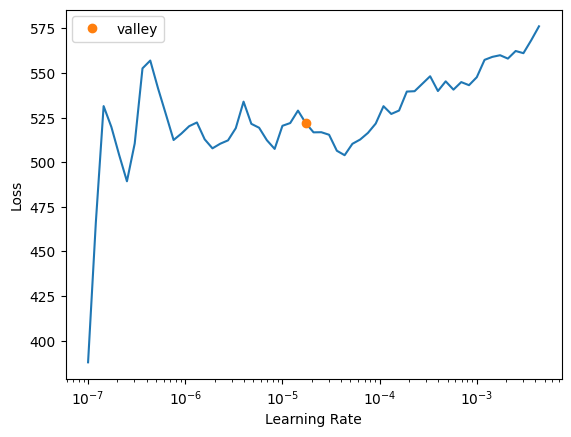

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the loss function with the provided thresholds and weights
loss = LossFactory(thresholds=thresholds, weights=weights).create(
    config.loss_func, **config.loss_config
).to(device)
print(loss)

# Set up metrics 
if config.metrics_handler_path is not None:
    metrics_handler = load_object(config.metrics_handler_path)
else:
    metrics_handler = GEODSTAPMetrics(loss, indices='geoap')
metrics = metrics_handler.get_metrics()

# Initialize the callback list, including WandbCallback if enabled
wandb_callback = WandbCallback(log_preds=False)
callbacks = L(wandb_callback) if config.wandb.enabled else L()
callbacks += ShowGraphCallback()

learn = TSForecaster(
    X, y, splits=splits, 
    batch_size=config.bs,
    pipelines=[preproc_pipe, exp_pipe], 
    arch=config.arch_name, 
    metrics=metrics,
    loss_func=loss,
    arch_config=dict(config.arch), 
    init=config.init_weights,
    cbs= callbacks, 
    partial_n=config.partial_n)
learn.to(device)

try: # In some extreme cases it can fail and return an error
    lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max
except:
    lr_max = 1e-3

learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

In [ ]:
if config.metrics_handler_path is not None:
    valid_metrics = learn.recorder.metrics 
else:
    valid_metrics = [AttrDict({
        "name": config.loss_func,
        "value": learn.validate()[0]
    })]

%store valid_metrics

print({metric.name: metric.value for metric in valid_metrics})

In [ ]:
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] 

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]

print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

In [ ]:
best_valid_metrics = None
%store -r best_valid_metrics

save_all_or_best = (
    config.is_optuna_study and 
    metrics_handler.are_best_values(best_valid_metrics, valid_metrics)
) or not config.is_optuna_study

if save_all_or_best:
    best_valid_metrics = valid_metrics
    %store best_valid_metrics                                            

    # Save locally and in wandb if online and enabled
    learn.save_all(path='tmp', verbose=True, model_fname='model_geoap', learner_fname="learner_geoap") 
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='geoap')
    
    # Save the best model
    model = {}
    model['models'] = [learn.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = config.data.data_columns
    model['thresholds'] = thresholds

    torch.save(model, 'models/best/best_model_geoap.pth')

In [ ]:
if run is not None:
    run.finish()